# Jojo Generator

03.09.2022

---

Jojo subtibles from Netflix, using the Language Reactor add-on: https://www.languagereactor.com/


In [1]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
from torch.utils.data import Dataset 
import torch
import time
import datetime
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import matplotlib
import matplotlib.pyplot as plt
import os
from os.path import join, splitext


In [2]:
data_dir='../data/'
df = pd.DataFrame()
for filename in os.listdir(data_dir):
    file_path = join(data_dir,filename)
    read_df = pd.read_excel(file_path)
    filename_ext_striped = splitext(filename)[0]
    read_df['Episode'] = filename_ext_striped
    df=pd.concat([df,read_df], ignore_index=True)
# pd.read_excel('../data/S1-E01.xlsx')

In [3]:
df["clean_subtitle"]=df.apply(lambda x: x["Translation"].replace('\n',' '), axis=1)
all_subtitles=df["clean_subtitle"].to_list()

In [4]:
len(all_subtitles)

28779

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<sos>', eos_token='<eos>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
max_len = max([len(tokenizer.encode(s)) for s in all_subtitles])
print(f"max_len: {max_len}")

max_len: 36


In [7]:
def tokenize_seq(sent,tokenizer,max_length):
  return tokenizer('<sos>'+ sent + '<eos>', truncation=True, max_length=max_length, padding="max_length")

class SubtitleDataset(Dataset):

  def __init__(self, sentences, tokenizer, gpt2_type="gpt2", max_length=max_len):

    self.tokenizer = tokenizer 
    self.input_ids = []
    self.attn_masks = []

    for sentence in sentences:      
      encodings = tokenize_seq(sentence,tokenizer,max_length)
            
      self.input_ids.append(torch.tensor(encodings['input_ids']))
      self.attn_masks.append(torch.tensor(encodings['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]   

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed))))) 

In [8]:
import gc
gc.collect() 

2531

In [9]:
#create an instance of Dataset
dataset = SubtitleDataset(all_subtitles, tokenizer, max_length=max_len)

# Split into training and validation sets
train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])
print("train_size :",train_size)
print("val_size   :",val_size)

gc.collect() 

train_size : 28491
val_size   : 288


0

In [10]:
dataset[0]

(tensor([50257,   464,   275,  1647,   599,  1127,   286,   428,  9335,   389,
          1498,   284,   366, 14689,     1,   262,  1692,  3632,  2252,    13,
         50258, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259, 50259,
         50259, 50259, 50259, 50259, 50259, 50259]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [11]:
train_dataloader = DataLoader(train_set,  sampler = RandomSampler(train_set), batch_size = 32)
validation_dataloader = DataLoader(val_set, sampler = SequentialSampler(val_set), batch_size = 32 )

In [12]:
# Create default config
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
# Load pretrained gpt2
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Create device
device = torch.device("cuda")
model.cuda()


optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005)
model = model.to(device)

In [13]:
#at every step i want to check if generations are getting better.
def eval_keywords(keywords):
  model.eval()
  for keyword in keywords:
    input_seq = "<sos> " + keyword
    generated = torch.tensor(tokenizer.encode(input_seq)).unsqueeze(0)
    generated = generated.to(device)
    sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=25, 
                                max_length = 32,
                                top_p=0.90, 
                                num_return_sequences=2
                                )
    for i, sample_output in enumerate(sample_outputs):
      print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

keywords = ["Jojo,","This","Wonder"]

In [14]:
 #call model with a batch of input
def process_one_batch(batch):
  b_input_ids = batch[0].to(device)
  b_labels = batch[0].to(device)
  b_masks = batch[1].to(device)
  outputs  = model(b_input_ids,  attention_mask = b_masks,labels=b_labels)
  return outputs

#do one epoch for training
def train_epoch():
  t0 = time.time()
  total_train_loss = 0
  model.train()
  for step, batch in enumerate(train_dataloader):
        
        model.zero_grad()        
        outputs = process_one_batch( batch)
        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()

        
  avg_train_loss = total_train_loss / len(train_dataloader)  
  print("avg_train_loss",avg_train_loss)  
  elapsed_time = format_time(time.time() - t0)
  print("elapsed time for 1 training epoch : ",elapsed_time)
  return avg_train_loss

#do one epoch for eval
def eval_epoch():
  t0 = time.time()
  total_eval_loss = 0
  nb_eval_steps = 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:            
        
    with torch.no_grad():        
      outputs = process_one_batch( batch)
      loss = outputs[0]              
      batch_loss = loss.item()
      total_eval_loss += batch_loss         

  avg_val_loss = total_eval_loss / len(validation_dataloader)
  print("avg_val_loss",avg_val_loss) 
  elapsed_time = format_time(time.time() - t0)
  print("elapsed time for 1 eval epoch : ",elapsed_time)
  return avg_val_loss

In [15]:
train_losses=[]
eval_losses=[]
for epoch in range(3):
    train_loss=train_epoch()
    train_losses.append(train_loss)
    eval_loss=eval_epoch()
    eval_losses.append(eval_loss)
    eval_keywords( keywords )

avg_train_loss 1.3559697095124943
elapsed time for 1 training epoch :  0:04:01


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


avg_val_loss 0.9159683916303847
elapsed time for 1 eval epoch :  0:00:01


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  Jojo, you know that I'm not in your way!
1:  Jojo, come on!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  This man must be dead!
1:  This is a Stand!
0:  Wonder why he's not wearing a uniform?
1:  Wonder why?
avg_train_loss 0.8837382353917517
elapsed time for 1 training epoch :  0:03:48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


avg_val_loss 0.8870358930693732
elapsed time for 1 eval epoch :  0:00:01


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  Jojo, do not let me out!
1:  Jojo, that's why I have to break out!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  This is my last chance!
1:  This thing can't be!
0:  Wonder why you're taking so long to make the coffee.
1:  Wonder if you could make my Hamon stronger.
avg_train_loss 0.7903000774608316
elapsed time for 1 training epoch :  0:03:45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


avg_val_loss 0.8933557271957397
elapsed time for 1 eval epoch :  0:00:01


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  Jojo, you fool!
1:  Jojo, please give us your blessing!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  This isn't an enemy Stand. It's just a duplicate of the enemy Stand.
1:  This time, you'll have to die a death match!
0:  Wonder why, you little bird.
1:  Wonder why?


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


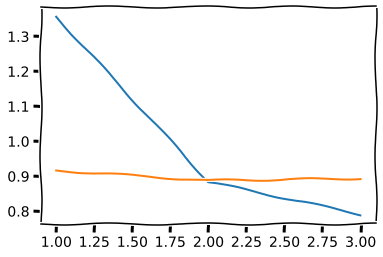

In [16]:
%matplotlib inline
with plt.xkcd():
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.plot(range(1,1+len(train_losses)), train_losses)  # Plot some data on the axes.
    ax.plot(range(1,1+len(eval_losses)), eval_losses)  # Plot some data on the axes.

In [17]:
model.save_pretrained('./gpt2_jojo_en')
tokenizer.save_pretrained('./gpt2_jojo_en')

('./gpt2_jojo_en/tokenizer_config.json',
 './gpt2_jojo_en/special_tokens_map.json',
 './gpt2_jojo_en/vocab.json',
 './gpt2_jojo_en/merges.txt',
 './gpt2_jojo_en/added_tokens.json')